In [3]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import random
from collections import namedtuple, deque

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


**Replay Memory**

In [4]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))

In [5]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen = self.capacity) # cyclic buffer of bounded size
    
    def __len__(self):
        return len(self.memory)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
        

**DQN**

In [6]:
class DQN(torch.nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,256), # only one hidden layer, the first two regarding the convolution as processing of input images are dropped
            torch.nn.ReLU(),
            torch.nn.Linear(256, n_actions)
        )
    
    def forward(self, x):
        return self.layers(x)
        

***Environment***

In [7]:
env = gym.make("MountainCarContinuous-v0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.001
EPS_DECAY = 0.995  #old value 0.9
REPLAY_MEMORY = 100000 
LR = 0.0005 #1e-4
GRID_SIZE = 10
disc_action_space = np.linspace(-1.0, 1.0, GRID_SIZE) # discretize action space

state, info = env.reset()
n_actions = GRID_SIZE  # continuous action space with 10 discrete actions 
n_observations = len(state)

memory = ReplayMemory(REPLAY_MEMORY)

estimate_network = DQN(n_observations, n_actions)
target_network = DQN(n_observations, n_actions)
target_network.load_state_dict(estimate_network.state_dict())

optimizer = torch.optim.AdamW(estimate_network.parameters(), lr = LR)

episode_durations = []

def discretize_action(action):
    i=np.argmin(np.abs(disc_action_space - action))
    return disc_action_space[i]

def act(state, eps):
    if random.random() < eps:
        return torch.tensor([np.digitize(env.action_space.sample(), disc_action_space)], device=device, dtype=torch.long)
    else: 
        with torch.no_grad(): # improves computation
            return estimate_network(state).max(1).indices.view(1,1)
        
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def converges(rewards):
    if (np.mean(rewards[-100:]) - np.mean(rewards[-200:-100])) < 1:
        return True
    return False


**Train**

In [14]:
episode_rewards = []
last_conv = 0
successful_sequences = 0
eps = EPS_START
for ep in range(1000): # number of episodes i think full training is 6000 episodes
    state, info = env.reset() # info in some environments has some additional information
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    episode_reward = 0
    

    while not done:
        
        action =  act(state, eps) # epsilon greedy 

        next_state, reward, terminated, truncated, _  = env.step([disc_action_space[action.item()]]) # execute action
        done = terminated or truncated
        episode_reward += reward
        
        
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) # get next state
        reward = torch.tensor(reward).to(device).float().unsqueeze(0) 
        done = torch.tensor(done).to(device).unsqueeze(0)

        memory.push(state, action, next_state, reward, done) # store transition in replay memory
        
        
        state = next_state
        
        if len(memory) > BATCH_SIZE: 
            transitions = memory.sample(BATCH_SIZE) # sample batch from replay memory
            batch = Transition(*zip(*transitions))
            # for action in batch.action:
            #     print(action.shape)

            next_state_batch = torch.cat(batch.next_state)
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)
            done_batch = torch.cat(batch.done)
            # determine if next state is terminal state (two approaches, one add done as part of the transition to the replay memory and second to try to determine it)
            # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
            # but this will only check if it s terminal in the batch and not overall the influnce of this would be interesting to check for sure
            
            y = reward_batch + (done_batch == False) * GAMMA * target_network(next_state_batch).max(1).values # compute target
            
            criterion = torch.nn.SmoothL1Loss() # criterion defined as Huber loss less sensitive to outliers
            loss = criterion(y, estimate_network(state_batch).gather(1, action_batch).squeeze(1)) # compute the loss
            
            optimizer.zero_grad() # not to accumulate gradients
            loss.backward() # backpropagate the loss
            for params in estimate_network.parameters():
                params.grad.data.clamp_(-1,1)
            # torch.nn.utils.clip_grad(estimate_network.parameters(), 1)  # why is clipping the parameters important do they get out of hand?       
            optimizer.step()
            # updating the target network
            # one approach soft update and second approach delayed update to estimated network parameters


    if ep % 5 == 0:
        target_network.load_state_dict(estimate_network.state_dict())
        

    eps = max(EPS_END, eps*EPS_DECAY) # decay epsilon
    episode_rewards.append(episode_reward) 
    
    # if ep - last_conv > 200 and converges(episode_rewards):
    #     eps = EPS_START
    #     last_conv = ep
    #     print('Resetting epsilon')


    if ep % 25 == 0:
        print('episode', ep, ':', np.mean(episode_rewards[-25:]), 'average score')
        

episode 0 : -34.8234567901236 average score
episode 25 : -0.2748641975310312 average score
episode 50 : 74.38498765432095 average score
episode 75 : 83.27051851851853 average score
episode 100 : 84.52103703703706 average score
episode 125 : 86.56735802469137 average score
episode 150 : 88.26246913580249 average score
episode 175 : 90.13866666666668 average score
episode 200 : 90.17659259259261 average score
episode 225 : 90.63925925925929 average score
episode 250 : 89.87051851851851 average score
episode 275 : 71.23106172839508 average score
episode 300 : 71.24883950617286 average score
episode 325 : 84.00029629629631 average score
episode 350 : 90.8097777777778 average score
episode 375 : 91.4935802469136 average score
episode 400 : 92.20444444444445 average score
episode 425 : 92.23925925925928 average score
episode 450 : 91.93925925925927 average score
episode 475 : 92.73293827160495 average score
episode 500 : 83.50562962962964 average score
episode 525 : 77.763012345679 average s

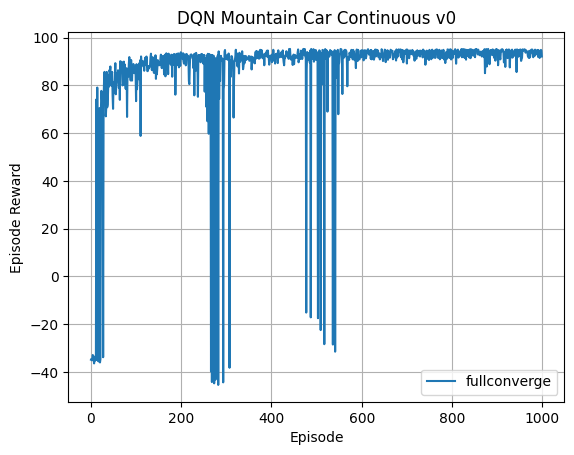

In [17]:
timesteps = np.arange(0, len(episode_rewards))
plt.plot(timesteps, episode_rewards, label='fullconverge')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('DQN Mountain Car Continuous v0')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Save the results
np.save('DQN_continous_seed11.npy', episode_rewards)


In [ ]:
env.close()
env = gym.make("MountainCarContinuous-v0", render_mode="human")

state, _ = env.reset()

state = torch.tensor(state).to(device).float().unsqueeze(0)
ep_count = 0
current_ep_reward = 0
scores = []
while ep_count < 50:
    env.render()
    action = act(state, 0)
    state, reward, terminated, truncated, _  = env.step([disc_action_space[action.item()]]) # execute action
    state = torch.tensor(state).to(device).float().unsqueeze(0)
    current_ep_reward += reward
    done = terminated or truncated 
    
    if done:
        ep_count += 1
        scores.append(current_ep_reward)
        current_ep_reward = 0
        state, _ = env.reset()
        state = torch.tensor(state).to(device).float().unsqueeze(0)


In [ ]:
print(scores)

[94.81024930747922, 93.85623268698062, 94.81024930747922, 94.91024930747923, 93.95789473684212, 94.2639889196676]
